In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product

import lightgbm as lgbm
from optuna import integration, logging

In [2]:
# feat = "feat01"
# train = pl.read_csv(f"feat/feat_train_{feat}.csv")
# test = pl.read_csv(f"feat/feat_test_{feat}.csv")

In [3]:
# each prediction
train_origin = pl.read_csv("data/train.csv")

clf_feat_lst = [
    "catboost_feat00", 
    "lgbm_feat01", 
    "randomforest_feat02", 
    "logisticregression_feat03", 
    "tabnet_feat03"
]

oof_pred_df_lst = [pl.read_csv(f"pred/oof_pred_{clf_feat}.csv") for clf_feat in clf_feat_lst]
test_pred_df_lst = [pl.read_csv(f"pred/test_pred_{clf_feat}.csv") for clf_feat in clf_feat_lst]

In [4]:
# tag for filename
clf_feat_stacking = "_".join(["lgbmstacking"] + [cf.split("_")[0] for cf in clf_feat_lst])

### train layer2 model (LGBM)

In [5]:
# Layer2特徴量：各特徴量(feat01) + 各モデルの予測確率
# train
train = pl.concat([pred_df.select(pl.all().name.prefix(f"model{i}_")) 
                   for i, pred_df in enumerate(oof_pred_df_lst)], how="horizontal")
train = train.with_columns(train_origin["health"])

# test
test = pl.concat([pred_df.select(pl.all().name.prefix(f"model{i}_")) 
                   for i, pred_df in enumerate(test_pred_df_lst)], how="horizontal")

cols_exp = [c for c in test.columns if c != "idx"]

### LGBM

In [6]:
def tune_lgbm_params(train, cols_exp, col_target):    
    params = {
        'objective': 'multiclass', 
        'num_class': 3, 
        "metric": "multi_logloss",
        # "force_col_wise": True, 
        "random_seed": 0, 
        'verbose': -1
    }

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # dataset
    train_set = integration.lightgbm.Dataset(x, y)

    # tuning with optuna
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    tuner = integration.lightgbm.LightGBMTunerCV(params=params, 
                                                train_set=train_set, 
                                                num_boost_round=100, 
                                                # num_boost_round=5, 
                                                folds=kf)
    
    logging.set_verbosity(logging.WARNING)
    tuner.run()

    params_tuned = tuner.best_params
    return params_tuned

In [7]:
def train_lgbm(train, cols_exp, col_target, params=None):
    
    if params is None:
        params = {}
        
    params_add = {
        'objective': 'multiclass', 
        'num_class': 3, 
        "n_estimators": 10000, 
        "metric": "multi_logloss",
        # "force_col_wise": True
    }
    params |= params_add

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    y_valid_pred_lst = []
    idx_valid_lst = []
    clf_lst = []

    # cross validation
    for fold, (idx_train, idx_valid) in enumerate(kf.split(x)):
        print("fold", fold)
        x_train = x[idx_train, :]
        x_valid = x[idx_valid, :]
        y_train = y[idx_train]
        y_valid = y[idx_valid]

        # lightgbm modeling
        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train, 
                eval_set=[(x_train, y_train), (x_valid, y_valid)],  
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=50),
                    lgbm.log_evaluation(period=10000),
                ])

        # oof
        y_valid_pred = clf.predict_proba(x_valid)
        y_valid_pred_lst.append(y_valid_pred)
        idx_valid_lst.append(idx_valid)
        clf_lst.append(clf)

    idx_valid = np.hstack(idx_valid_lst)
    y_valid_pred = np.vstack(y_valid_pred_lst)
    oof_pred = y_valid_pred[np.argsort(idx_valid)]

    return clf_lst, oof_pred

In [8]:
def predict_test(x_test, clf_lst):
    y_test_pred_lst = []

    for clf in clf_lst:
        y_test_pred = clf.predict_proba(x_test)
        y_test_pred_lst.append(y_test_pred)

    y_test_pred = np.mean(y_test_pred_lst, axis=0)
    return y_test_pred

In [9]:
col_target = "health"

# parameter tuning with optuna
params_tuned = tune_lgbm_params(train, cols_exp, col_target)

# train LGBM model
clf_lst, oof_pred = train_lgbm(train, cols_exp, col_target, params_tuned)

# predict test with CV ensemble
y_test_pred = predict_test(test[cols_exp].to_numpy(), clf_lst)

# record
oof_pred_df = pl.DataFrame(oof_pred, schema=[f"health_is_{h}" for h in range(3)])
test_pred_df = pl.DataFrame(y_test_pred, schema=[f"health_is_{h}" for h in range(3)])

[I 2024-01-04 21:35:59,984] A new study created in memory with name: no-name-52f79b78-abc1-4a54-a4d5-726d0110e15a
min_child_samples, val_score: 0.600331: 100%|##########| 5/5 [00:01<00:00,  2.95it/s]


fold 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.595047	valid_1's multi_logloss: 0.601394
fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's multi_logloss: 0.594526	valid_1's multi_logloss: 0.605068
fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.60101	valid_1's multi_logloss: 0.584733
fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.594343	valid_1's multi_logloss: 0.599812
fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.593547	valid_1's multi_logloss: 0.608091


In [10]:
# save
oof_pred_df.write_csv(f"pred/oof_pred_{clf_feat_stacking}.csv")
test_pred_df.write_csv(f"pred/test_pred_{clf_feat_stacking}.csv")

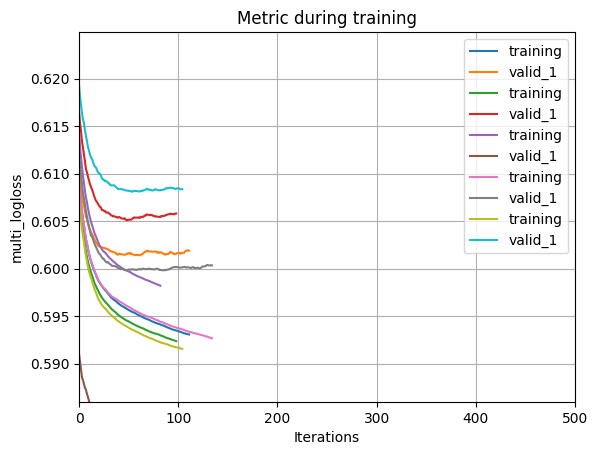

In [11]:
fig, ax = plt.subplots()
for model in clf_lst:
    lgbm.plot_metric(model, ax=ax)
ax.set_xlim(0, 500)
plt.show()
plt.close()

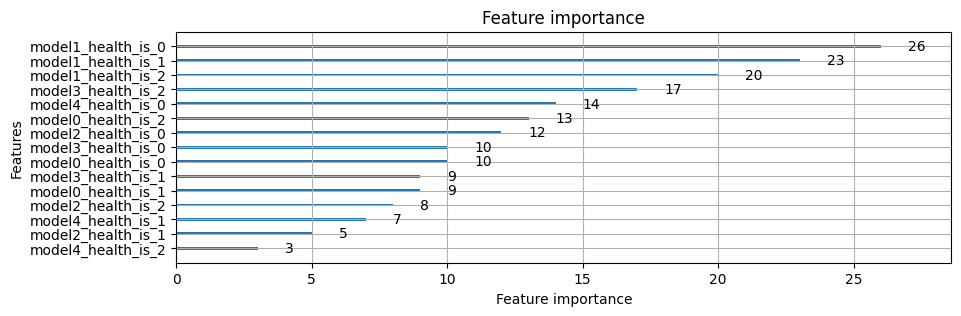

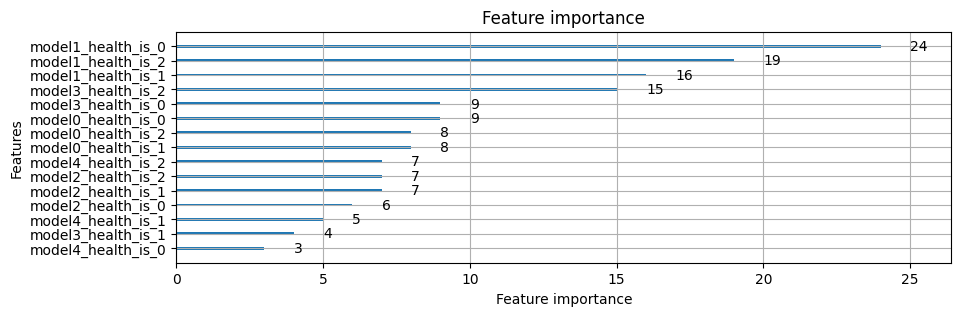

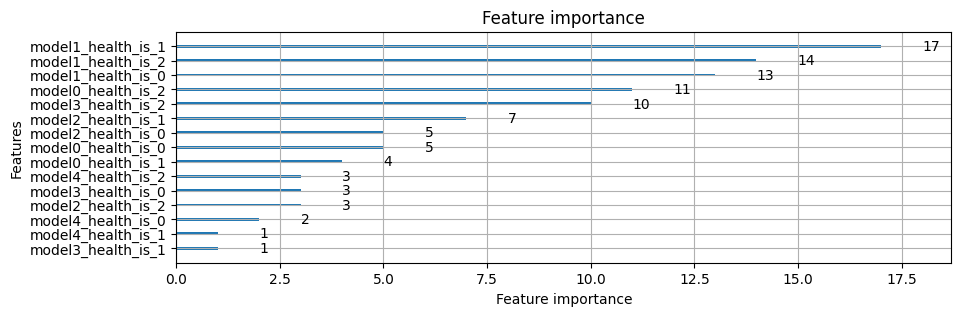

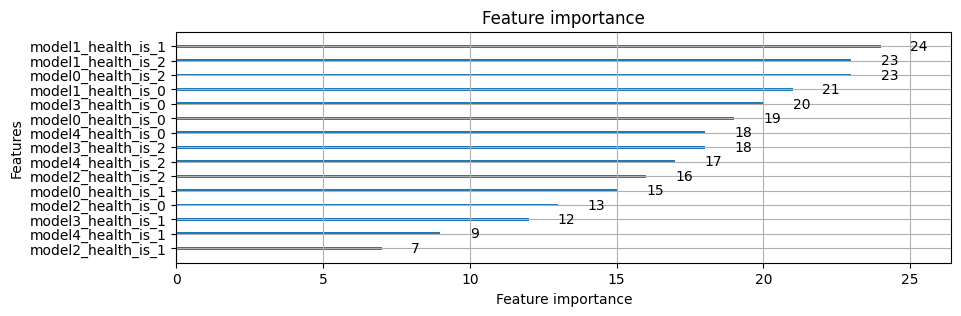

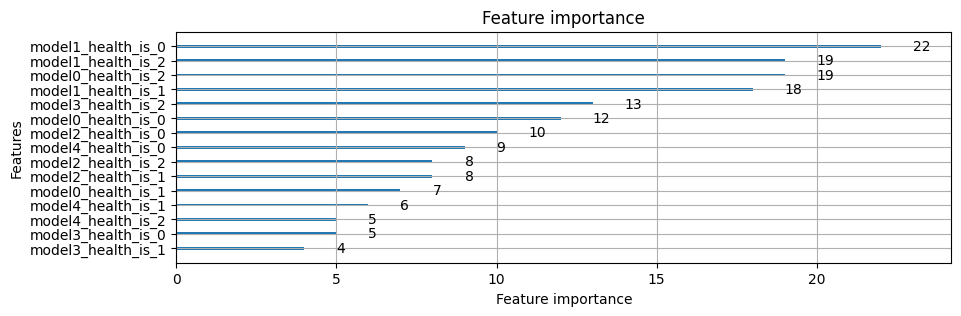

In [14]:
for model in clf_lst:
    fig, ax = plt.subplots(figsize=(10, 3))
    lgbm.plot_importance(model, ignore_zero=False, ax=ax)
    ax.set_yticks(np.arange(len(cols_exp)), np.array(cols_exp)[np.argsort(model.feature_importances_)])
    plt.show()
    plt.close()